In [1]:
#Library imports for torch

import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

torch.manual_seed(10)

In [2]:
# Initializing dataloaders for the CIFAR-10 dataset

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle=True)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# CNN network implementation

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x        
    
    def _initialize_weights(self, module):
        if isinstance(module, nn.Conv2d):
            nn.init.normal_(module.weight, mean = 0, std=1)

In [4]:
# CNN training 

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lr=0.01, params=net.parameters())

import time
import math

training_log = []

start_time = time.time()

for epoch in range(2):
    
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
                
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f"[{epoch + 1}, {i + 1:5d}] loss:{running_loss / 2000:.3f}")
            training_log.append([math.ceil(time.time() - start_time), running_loss/2000])
            running_loss = 0.0
    
print("Finished Training")

file = open("cnn.log", "w")
file.write("time,loss")

for line in training_log:
    file.write("\n")
    file.write(",".join([str(x) for x in line]))

file.close()

[1,  2000] loss:2.186
[1,  4000] loss:1.829
[1,  6000] loss:1.640
[1,  8000] loss:1.536
[1, 10000] loss:1.456
[1, 12000] loss:1.434
[2,  2000] loss:1.364
[2,  4000] loss:1.320
[2,  6000] loss:1.319
[2,  8000] loss:1.270
[2, 10000] loss:1.259
[2, 12000] loss:1.254
Finished Training


              precision    recall  f1-score   support

       plane       0.58      0.67      0.62       871
         car       0.70      0.67      0.68      1048
        bird       0.45      0.50      0.47       899
         cat       0.34      0.40      0.37       853
        deer       0.51      0.47      0.49      1089
         dog       0.42      0.52      0.47       809
        frog       0.58      0.72      0.64       818
       horse       0.74      0.57      0.64      1311
        ship       0.78      0.55      0.64      1423
       truck       0.58      0.66      0.62       879

    accuracy                           0.57     10000
   macro avg       0.57      0.57      0.56     10000
weighted avg       0.59      0.57      0.57     10000



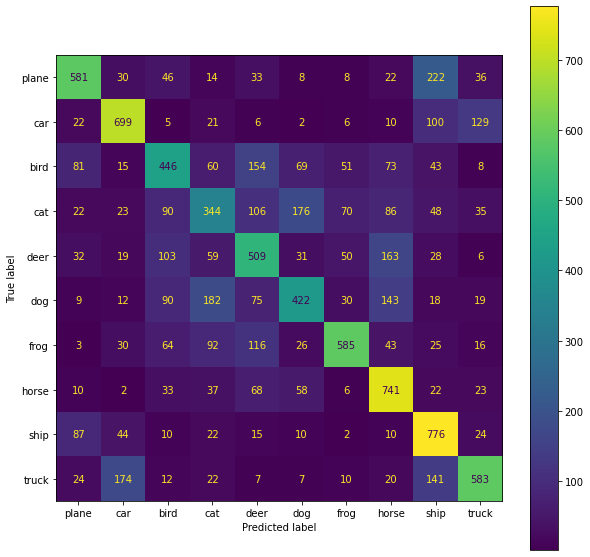

In [5]:
# CNN model testing 

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd
import matplotlib.pyplot as plt


total = 0
correct = 0


predictions = []
actuals = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        
        actuals.extend(labels)
        predictions.extend(predicted)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
cf_matrix = confusion_matrix(y_pred = predictions, y_true = actuals)

cd = ConfusionMatrixDisplay(cf_matrix, display_labels=classes)

fig, ax = plt.subplots(figsize=(10,10))
cd.plot(ax=ax)

confusion_matrix = pd.DataFrame(cf_matrix, columns=classes, index=classes)

fig.savefig("images/cnn.png")        
    

print(classification_report(predictions, actuals, target_names=classes))